In [1]:
#Import and initiate spark
import findspark
findspark.init()
findspark.find()

'C:\\Users\\manmi\\anaconda3\\lib\\site-packages\\pyspark'

In [29]:
#Import librabries
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, avg, count, col, asc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [30]:
# Initialize SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [31]:
# Load the dataset
yelp_df = spark.read.csv("Downloads/archive/yelp_database.csv", header=True, inferSchema=True)

In [7]:
# Display the contents of the dataset
yelp_df.show()

+---+--------------+-----------+--------------------+----+------+------------+--------+-------+-----------+-----+--------------+--------------------+--------+
| ID|      Time_GMT|      Phone|        Organization| OLF|Rating|NumberReview|Category|Country|CountryCode|State|          City|              Street|Building|
+---+--------------+-----------+--------------------+----+------+------------+--------+-------+-----------+-----+--------------+--------------------+--------+
|  1|3/12/2021 2:10|12562343500|  The Station's Best|null|   4.0|           4|Delivery|    USA|         US|   AL|Alexander City|           Jefferson|     977|
|  2|3/12/2021 2:10|12566758004|           Pizza Hut|null|   3.0|           6|Delivery|    USA|         US|   AL|Alexander City|            4581 Hwy|    4581|
|  3|3/12/2021 2:10|12562342181|Zaxby's Chicken F...|null|   3.0|          13|Delivery|    USA|         US|   AL|Alexander City|        4497 Highway|    4497|
|  4|3/12/2021 2:10|12564097272|   Papa John's

In [8]:
#Exploratory Data Analysis
# Calculate average star rating by business and display the top 10 businesses with highest average star ratings
avg_rating_by_business = yelp_df.groupBy("Organization") \
    .avg("Rating") \
    .withColumnRenamed("avg(Rating)", "average_rating") \
    .orderBy(desc("average_rating"))
top_10_businesses = avg_rating_by_business.limit(10)
top_10_businesses.show()

+--------------------+--------------+
|        Organization|average_rating|
+--------------------+--------------+
|               Gegen|           5.0|
|     Meals By Chef B|           5.0|
|Canaan Restaurant...|           5.0|
|Healthy and Fresh...|           5.0|
|    Hug Thai Express|           5.0|
|            Naciamaj|           5.0|
|             Barvida|           5.0|
|KC's Country Kitc...|           5.0|
|   Food4Fuel Kitchen|           5.0|
|   Coffeehouse Ten24|           5.0|
+--------------------+--------------+



In [10]:
# Find the top 10 most reviewed businesses
top_10_most_reviewed = yelp_df.groupBy("Organization") \
    .count() \
    .orderBy(desc("count")) \
    .limit(10)
top_10_most_reviewed.show()

+------------------+-----+
|      Organization|count|
+------------------+-----+
|    Domino's Pizza| 6956|
|            Subway| 6775|
|         Pizza Hut| 6400|
|               KFC| 4289|
|      Jimmy John's| 4014|
| Papa John's Pizza| 3857|
|            Arby's| 3611|
|      Panera Bread| 3318|
|     Panda Express| 2971|
|Jersey Mike's Subs| 2817|
+------------------+-----+



+--------------------+------------+
|            Category|review_count|
+--------------------+------------+
|            Plumbing|      510305|
|            Delivery|      348522|
|Air Conditioning ...|      141173|
+--------------------+------------+



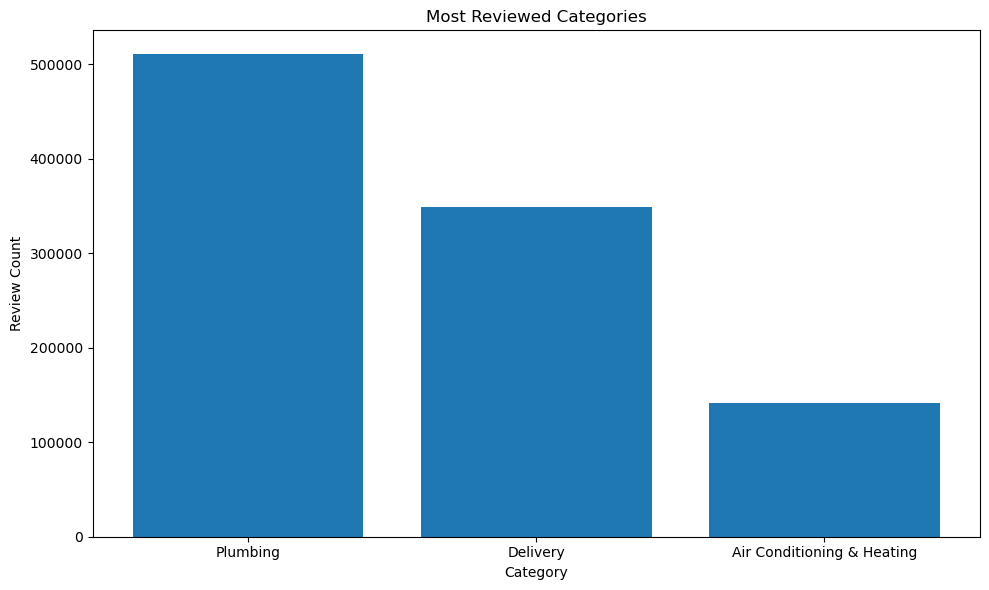

In [40]:
# Find the most reviewed categories
popular_categories = yelp_df.groupBy("Category") \
    .agg(count("*").alias("review_count")) \
    .orderBy(desc("review_count"))
popular_categories.show()

# Extracting category names and review counts from the DataFrame
categories = popular_categories.select("Category").rdd.flatMap(lambda x: x).collect()
review_counts = popular_categories.select("review_count").rdd.flatMap(lambda x: x).collect()

# Creating a bar graph
plt.figure(figsize=(10, 6))
plt.bar(categories, review_counts)
plt.xlabel("Category")
plt.ylabel("Review Count")
plt.title("Most Reviewed Categories")
plt.tight_layout()
plt.show()

+--------------------+------------------+
|            Category|    average_rating|
+--------------------+------------------+
|            Delivery| 3.553990852801258|
|            Plumbing|2.1633052782159687|
|Air Conditioning ...|3.1293838056852232|
+--------------------+------------------+



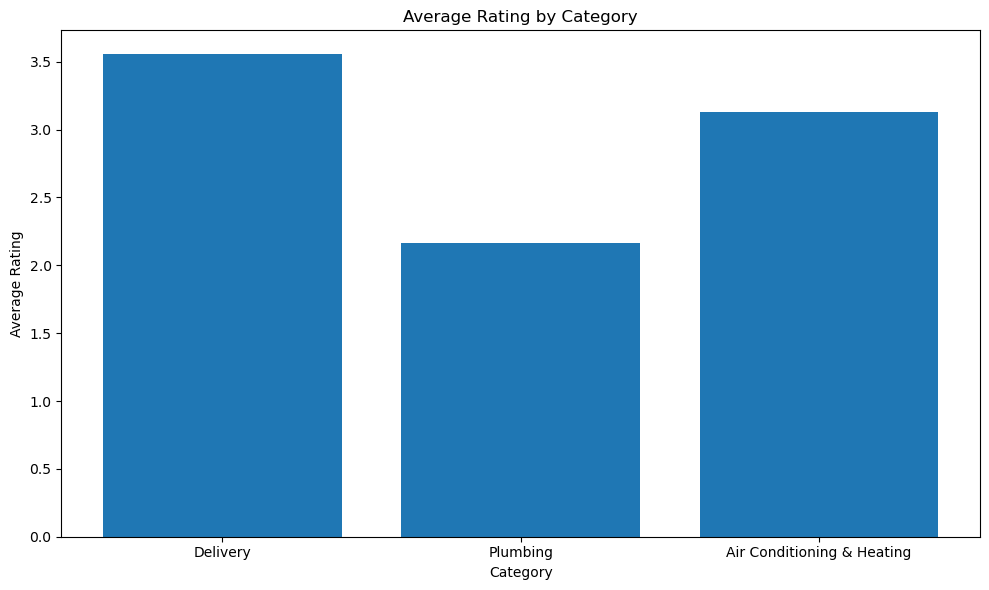

In [41]:
# Calculate the average rating for each category
avg_rating_by_category = yelp_df.groupBy("Category") \
    .agg(avg(yelp_df["Rating"]).alias("average_rating"))
avg_rating_by_category.show()
# Extracting category names and average ratings from the DataFrame
categories = avg_rating_by_category.select("Category").rdd.flatMap(lambda x: x).collect()
average_ratings = avg_rating_by_category.select("average_rating").rdd.flatMap(lambda x: x).collect()

# Creating a bar graph
plt.figure(figsize=(10, 6))
plt.bar(categories, average_ratings)
plt.xlabel("Category")
plt.ylabel("Average Rating")
plt.title("Average Rating by Category")
plt.tight_layout()
plt.show()

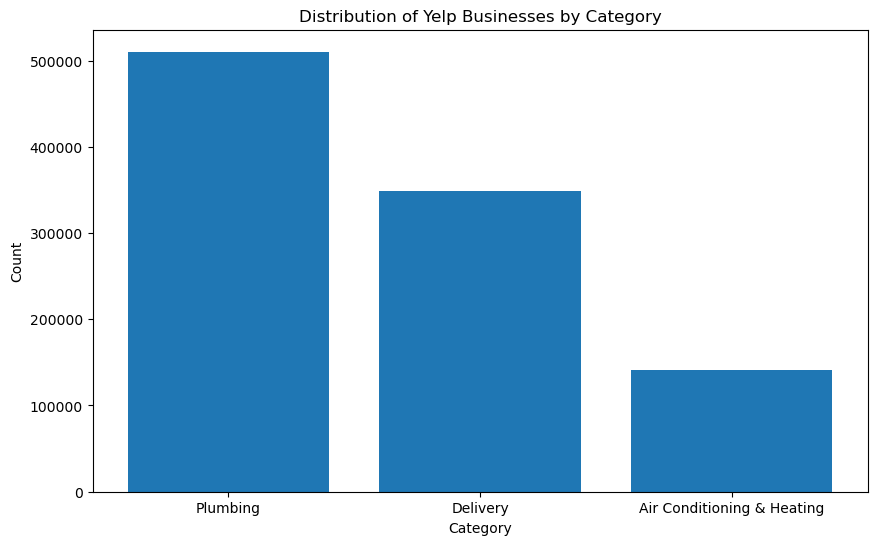

In [16]:
import pyspark.sql.functions as F
# Create a DataFrame with aggregated counts by category
category_counts = yelp_df.groupBy("Category").count().orderBy(F.desc("count"))

# Convert the DataFrame to Pandas for plotting
category_counts_pd = category_counts.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts_pd["Category"], category_counts_pd["count"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Yelp Businesses by Category")
plt.show()

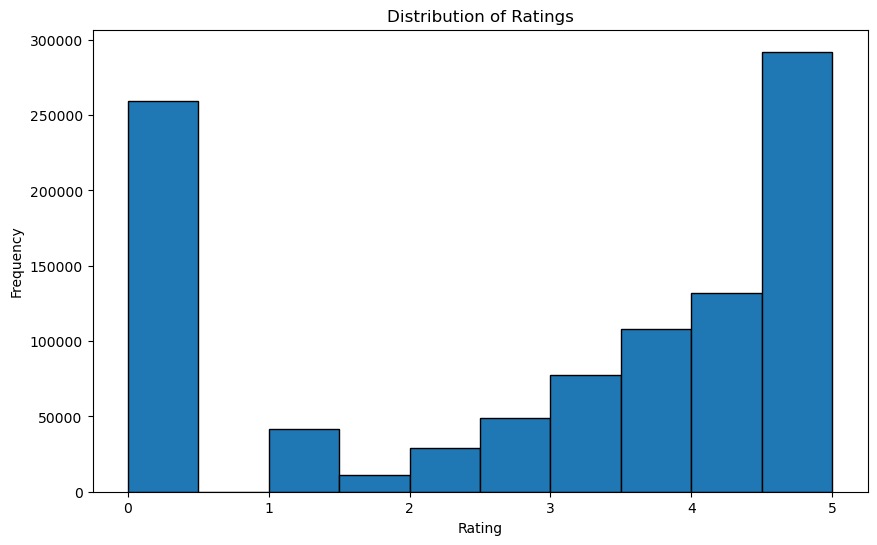

In [17]:
import pyspark.sql.functions as F

# Select the 'Rating' column
rating_column = yelp_df.select("Rating")

# Convert the DataFrame to Pandas for plotting
rating_pd = rating_column.toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(rating_pd["Rating"], bins=10, edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

+-------------+-----+
|         City|count|
+-------------+-----+
|  Los Angeles|13423|
|      Chicago|11730|
|     New York| 9353|
|     Brooklyn| 8338|
|       Boston| 5495|
|Oklahoma City| 4639|
|      Phoenix| 4628|
| Philadelphia| 4572|
|     San Jose| 4475|
|       Denver| 4436|
|        Miami| 4268|
|San Francisco| 4145|
|      Oakland| 3986|
|    San Diego| 3940|
|  Springfield| 3781|
|    Las Vegas| 3744|
|     Columbus| 3711|
|      Anaheim| 3499|
|     Portland| 3399|
|  Kansas City| 3212|
+-------------+-----+
only showing top 20 rows



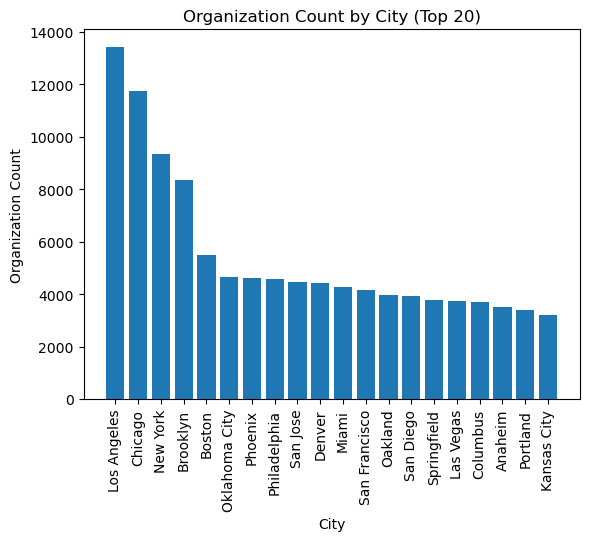

In [18]:
# Create a DataFrame with aggregated counts of organisations by city
org_count_by_city = df.groupBy("City").agg(count("Organization").alias("count"))
org_count_by_city = org_count_by_city.orderBy(col("count").desc())
org_count_by_city.show(20)
# Convert the top 20 cities' organization count to Pandas DataFrame for plotting
org_count_pd = org_count_by_city.limit(20).toPandas()
# Plot a scatter plot of the organization count
plt.bar(org_count_pd['City'],org_count_pd['count'])
plt.xlabel('City')
plt.ylabel('Organization Count')
plt.title('Organization Count by City (Top 20)')
plt.xticks(rotation=90)
plt.show()

In [20]:
#Clustering Algorithm
# Select the relevant features for clustering
selected_features = ['Rating', 'NumberReview']

# Create a VectorAssembler to combine the selected features into a feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Transform the DataFrame to include the feature vector
feature_vector_df = assembler.transform(df)

# Set the number of clusters
k = 3

# Create a KMeans instance
kmeans = KMeans(featuresCol="features", k=k)

# Fit the KMeans model to the data
model = kmeans.fit(feature_vector_df)

# Get the cluster assignments for each business
clustered_df = model.transform(feature_vector_df)

# Show the cluster assignments
clustered_df.show()

# Obtain the cluster centers
cluster_centers = model.clusterCenters()

# Print the coordinates of each cluster center
for i, center in enumerate(cluster_centers):
    print("Cluster", i, "Center:", center)

+---+--------------+-----------+--------------------+----+------+------------+--------+-------+-----------+-----+--------------+--------------------+--------+----------+----------+
| ID|      Time_GMT|      Phone|        Organization| OLF|Rating|NumberReview|Category|Country|CountryCode|State|          City|              Street|Building|  features|prediction|
+---+--------------+-----------+--------------------+----+------+------------+--------+-------+-----------+-----+--------------+--------------------+--------+----------+----------+
|  1|3/12/2021 2:10|12562343500|  The Station's Best|null|   4.0|           4|Delivery|    USA|         US|   AL|Alexander City|           Jefferson|     977| [4.0,4.0]|         0|
|  2|3/12/2021 2:10|12566758004|           Pizza Hut|null|   3.0|           6|Delivery|    USA|         US|   AL|Alexander City|            4581 Hwy|    4581| [3.0,6.0]|         0|
|  3|3/12/2021 2:10|12562342181|Zaxby's Chicken F...|null|   3.0|          13|Delivery|    USA|

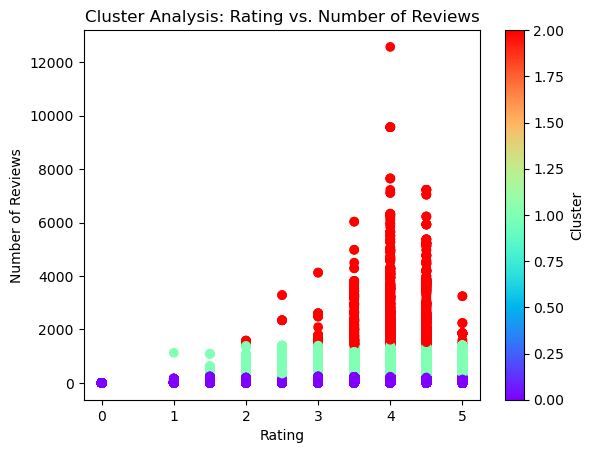

In [21]:
# Cluster Analysis Visualisation
# Convert the entire DataFrame to Pandas
clustered_df_pd = clustered_df.toPandas()

# Extract the feature values for the scatter plot
ratings = clustered_df_pd['Rating']
num_reviews = clustered_df_pd['NumberReview']
cluster_labels = clustered_df_pd['prediction']

# Create a scatter plot
plt.scatter(ratings, num_reviews, c=cluster_labels, cmap='rainbow')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Cluster Analysis: Rating vs. Number of Reviews')

# Show the colorbar legend for clusters
plt.colorbar(label='Cluster')

# Show the plot
plt.show()